miro: https://miro.com/app/board/uXjVO4ZVRm0=/?share_link_id=831889139340

In [64]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

seed = 0
torch.manual_seed(seed) # Set for testing purposes, please do not change!

import numpy as np

A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph.

In [35]:
from torch.autograd import Variable

Weight normalization is a reparameterization that decouples the magnitude of a weight tensor from its direction. 

In [36]:
from torch.nn.utils import weight_norm

## Dataset and Preprocessing:
MNIST dataset can be loaded using the datasets module from torchvision.

We download the images, turn the numpy arrays into torch tensors, and apply pixel normalization.

In [37]:
from torchvision import transforms as tfs
from torchvision import datasets as dts

In [38]:
def prepare_mnist():
    # normalize data
    m = (0.1307,)
    st = (0.3081,)
    normalize = tfs.Normalize(m, st)
        
    # load train data
    train_dataset = dts.MNIST(root='../data', 
                               train=True, 
                               transform=tfs.Compose([tfs.ToTensor(),
                                                       normalize]),  
                               download=True)
    
    # load test data
    test_dataset = dts.MNIST(root='../data', 
                              train=False, 
                              transform=tfs.Compose([tfs.ToTensor(), 
                                                      normalize]))
    
    return train_dataset, test_dataset

In [39]:
train_dataset, test_dataset = prepare_mnist()

train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

retrieve the data

In [40]:
from utils import sample_train

k=100
batch_size=100
n_classes=10
            
# make data loaders
train_loader, test_loader, indices = sample_train(train_dataset, test_dataset, batch_size,
                                                  k, n_classes, seed, shuffle_train=False)


In [41]:
n = len(train_dataset)
rrng = np.random.RandomState(seed)

cpt = 0
indices = torch.zeros(k)
other = torch.zeros(n - k)
card = k // n_classes

for i in range(n_classes):
    class_items = (train_dataset.train_labels == i).nonzero()
    n_class = len(class_items)
    rd = np.random.permutation(np.arange(n_class))
    indices[i * card: (i + 1) * card] = class_items[rd[:card],0]
    other[cpt: cpt + n_class - card] = class_items[rd[card:],0]
    cpt += n_class - card

other = other.long()
train_dataset.train_labels[other] = -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


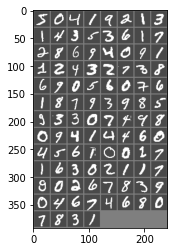

In [42]:
# functions to show an image
from torchvision.utils import make_grid


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels

In [43]:
labels

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

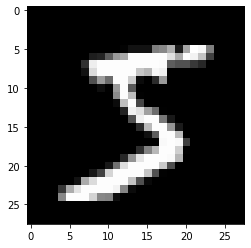

In [44]:
imshow(images[0])

Gaussian noise (centered) is applied to the inputs. The standard deviation chosen defines the aggressiveness of the transformation we want to teach the network to be robust to.

In [45]:
class GaussianNoise(nn.Module):
    
    def __init__(self, shape=(100, 1, 28, 28), std=0.05):
        super(GaussianNoise, self).__init__()
        self.noise = Variable(torch.zeros(shape).cuda())
        self.std = std
        
    def forward(self, x):
        c = x.shape[0]
        self.noise.data.normal_(0, std=self.std)
        return x + self.noise[:c]

In [46]:
noise = GaussianNoise(shape=(1, 1, 28, 28), std=0.05)
image_aug = noise(images[0].cuda())

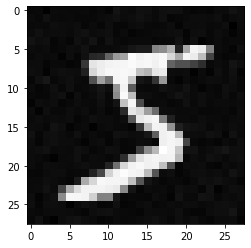

In [47]:
imshow(image_aug[0].cpu())

### unsupervised cost weight


The unsupervised component is weighted by a function ($w_{T}$) that slowly ramps up.

$w_{T}(t) = \exp(-5(1 - \frac{t}{T})^{2})$

unsupervised loss weight : 0.0009740835053472244
unsupervised loss weight : 0.0027318847495129677
unsupervised loss weight : 0.0065534508315721485
unsupervised loss weight : 0.013446808012990042
unsupervised loss weight : 0.023599883024449233
unsupervised loss weight : 0.035427620478902945
unsupervised loss weight : 0.04548996514767851
unsupervised loss weight : 0.0499609527548162
unsupervised loss weight : 0.05
unsupervised loss weight : 0.05


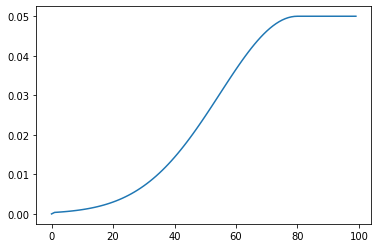

In [66]:
from utils import weight_schedule

max_epochs=80
n_samples=60000
max_val=30.
ramp_up_mult=-5.
W = []

for epoch in range(100):

    w = weight_schedule(epoch, max_epochs, max_val, ramp_up_mult, k, n_samples)

    if (epoch + 1) % 10 == 0:
        print ('unsupervised loss weight : {}'.format(w))

    w = torch.autograd.Variable(torch.FloatTensor([w]).cuda(), requires_grad=False)
    
    W.append(w.cpu())
    
plt.plot(W)
plt.show()

## The model
We will use a simple ConvNet with 2 Conv layers, ReLU activations, and one fully connected layer.

In [67]:
class CNN(nn.Module):
    def __init__(self, std):
        super(CNN, self).__init__()
        self.std   = std
        self.gn    = GaussianNoise(std=self.std)
        self.act   = nn.ReLU()
        self.drop  = nn.Dropout(0.5)
        self.conv1 = weight_norm(nn.Conv2d(1, 16, 3, padding=1))
        self.conv2 = weight_norm(nn.Conv2d(16, 32, 3, padding=1))
        self.mp    = nn.MaxPool2d(3, stride=2, padding=1)
        self.fc    = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        if self.training:
            x = self.gn(x)
        x = self.act(self.mp(self.conv1(x)))
        x = self.act(self.mp(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.drop(x)
        x = self.fc(x)
        return x

build the model

In [68]:
model = CNN(0.3)
model.cuda()

CNN(
  (gn): GaussianNoise()
  (act): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

### Training

`model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

In [96]:
model.train()

CNN(
  (gn): GaussianNoise()
  (act): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

setup param optimization

In [69]:
lr=0.002

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

In [87]:
# train
# model.train()
losses = []
sup_losses = []
unsup_losses = []
best_loss = 20.

The loss function we use is a linear combination of the masked crossentropy and the mean square error between the current outputs $(z_i)$ and the temporal outputs $(\tilde{z}_i)$ :

$l_{B}(z, \tilde{z}, y) = masked\_crossentropy(z, y) + w(t) * MSE(z, \tilde{z})$

In [71]:
ntrain = len(train_dataset)
print("ntrain",ntrain)
print("n_classes",n_classes)

ntrain 60000
n_classes 10


In [72]:
Z = torch.zeros(ntrain, n_classes).float().cuda()        # intermediate values
z = torch.zeros(ntrain, n_classes).float().cuda()        # temporal outputs
outputs = torch.zeros(ntrain, n_classes).float().cuda()  # current outputs

The masked crossentropy takes only into account samples that possess a label. Calling $B$ the set of minibatch indices, $L$ the set of indices of labeled examples and $C$ the amount of classes, it is expressed this way
$$ masked\_crossentropy(z, y) = - \frac{1}{\mid B \cap L \mid} \sum_{i \in (B \cap L)}{\log{z_{i}[y_{i}]}}$$

and mean square error is calculated like this :
$$MSE(z, \tilde{z}) = \frac{1}{C \mid B \mid} \sum_{i \in B}{\mid \mid z_{i} - \tilde{z}_{i} \mid \mid ^{2}}$$

In [60]:
def temporal_loss(out1, out2, w, labels):
    
    # MSE between current and temporal outputs
    def mse_loss(out1, out2):
        quad_diff = torch.sum((F.softmax(out1, dim=1) - F.softmax(out2, dim=1)) ** 2)
        return quad_diff / out1.data.nelement()
    
    def masked_crossentropy(out, labels):
        nbsup = len(torch.nonzero(labels >= 0))
        loss = F.cross_entropy(out, labels, size_average=False, ignore_index=-1)
        if nbsup != 0:
            loss = loss / nbsup
        return loss, nbsup
    
    sup_loss, nbsup = masked_crossentropy(out1, labels)
    unsup_loss = mse_loss(out1, out2)
    return sup_loss + w * unsup_loss, sup_loss, unsup_loss, nbsup

### Update temporal ensemble

After each epoch, we update the temporal outputs  $$Z = \alpha  Z + (1 - \alpha) z$$

In [86]:
alpha=0.6

### Training Loop

In each minibatch, we calculate the model output and the loss based on the previous outputs and the available labels.

In [94]:
from timeit import default_timer as timer

num_epochs = 150
c=300

for epoch in range(num_epochs):
    t = timer()
    
    # evaluate unsupervised cost weight
    w = weight_schedule(epoch, max_epochs, max_val, ramp_up_mult, k, n_samples)
 
    if (epoch + 1) % 10 == 0:
        print ('unsupervised loss weight : {}'.format(w))
    
    # turn it into a usable pytorch object
    w = torch.autograd.Variable(torch.FloatTensor([w]).cuda(), requires_grad=False)
    
    l = []
    supl = []
    unsupl = []
    for i, (images, labels) in enumerate(train_loader):  
        images = Variable(images.cuda())
        labels = Variable(labels.cuda(), requires_grad=False)

        # get output and calculate loss
        optimizer.zero_grad()
        out = model(images)
        zcomp = Variable(z[i * batch_size: (i + 1) * batch_size], requires_grad=False)
        loss, suploss, unsuploss, nbsup = temporal_loss(out, zcomp, w, labels)
        # save outputs and losses
        outputs[i * batch_size: (i + 1) * batch_size] = out.data.clone()
        l.append(loss.data[0].cpu())
        supl.append(nbsup * suploss.data.cpu())
        unsupl.append(unsuploss.data.cpu())

        # backprop
        loss.backward()
        optimizer.step()

        # print loss
        if (epoch + 1) % 10 == 0:
            if i + 1 == 2 * c:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.6f, Time (this epoch): %.2f s' 
                       % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, np.mean(l), timer() - t))
            elif (i + 1) % c == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.6f' 
                       % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, np.mean(l)))

    # update temporal ensemble
    Z = alpha * Z + (1. - alpha) * outputs
    # Since Z is initialized as a zero tensor, 
    # after the first epoch we have Z=(1−α)z. 
    # We fix this startup bias this way :
    z = Z * (1. / (1. - alpha ** (epoch + 1)))

    # handle metrics, losses, etc.
    eloss = np.mean(l)
    losses.append(eloss)
    sup_losses.append((1. / k) * np.sum(supl))  # divide by 1/k to obtain the mean supervised loss
    unsup_losses.append(np.mean(unsupl))
    
    # saving model 
    if eloss < best_loss:
        best_loss = eloss
        torch.save({'state_dict': model.state_dict()}, 'model_best.pth.tar')

unsupervised loss weight : 0.0009740835053472244
Epoch [10/150], Step [300/600], Loss: 0.067634
Epoch [10/150], Step [600/600], Loss: 0.049223, Time (this epoch): 5.04 s
unsupervised loss weight : 0.0027318847495129677
Epoch [20/150], Step [300/600], Loss: 0.029235
Epoch [20/150], Step [600/600], Loss: 0.026639, Time (this epoch): 5.16 s
unsupervised loss weight : 0.0065534508315721485
Epoch [30/150], Step [300/600], Loss: 0.031415
Epoch [30/150], Step [600/600], Loss: 0.018069, Time (this epoch): 5.05 s
unsupervised loss weight : 0.013446808012990042
Epoch [40/150], Step [300/600], Loss: 0.005061
Epoch [40/150], Step [600/600], Loss: 0.015506, Time (this epoch): 5.07 s
unsupervised loss weight : 0.023599883024449233
Epoch [50/150], Step [300/600], Loss: 0.028531
Epoch [50/150], Step [600/600], Loss: 0.016429, Time (this epoch): 5.07 s
unsupervised loss weight : 0.035427620478902945
Epoch [60/150], Step [300/600], Loss: 0.001631
Epoch [60/150], Step [600/600], Loss: 0.009629, Time (thi

In [95]:
def calc_metrics(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        samples = Variable(samples.cuda(), volatile=True)
        labels = Variable(labels.cuda())
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data.view_as(predicted)).sum()

    acc = 100 * float(correct) / total
    return acc

In [99]:
model.eval()
acc = calc_metrics(model, test_loader)
print ('Accuracy of the network on the 10000 test images: %.2f %%' % (acc))

/tmp/ipykernel_14247/3889208023.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  samples = Variable(samples.cuda(), volatile=True)


Accuracy of the network on the 10000 test images: 95.68 %


* https://ferretj.github.io/ml/2018/01/22/temporal-ensembling.html
* TEMPORAL ENSEMBLING FOR SEMI-SUPERVISED LEARNING https://arxiv.org/pdf/1610.02242.pdf
* https://github.com/ferretj/temporal-ensembling